<a href="https://colab.research.google.com/github/EldarEyvazov/PolypSegmentation/blob/main/Kvasir_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
# File processing
from glob import glob
import json
from PIL import Image
from tqdm import tqdm

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split


In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

True
cuda


# Exploring the dataset




**Verifying file format and quantity**

In [ ]:
#defining the path to Kvasir-seg dataset
#also for images and masks
masks_dir = "/content/drive/MyDrive/Kvasir-SEG/masks"
image_dir = "/content/drive/MyDrive/Kvasir-SEG/images"

#list of filenames in subdirecotires
image_files = os.listdir(image_dir)
mask_files = os.listdir(masks_dir)

#checking the file format for both images and masks
import os


# Extract the file formats
file_formats = set([file.split(".")[-1] for file in image_files])
print(f"There are {len(image_files)} images with {file_formats} format")

#same for the masks
mask_formats = set([mask.split(".")[-1] for mask in mask_files])
print(f"There are {len(mask_files)} masks with {mask_formats} format")


There are 1000 images with {'jpg'} format
There are 1000 masks with {'jpg'} format


In [ ]:
#checking filenames for both images and masks
print("---Image file names---")
image_files[:5]


---Image file names---


['cjyzjzssvd8pq0838f4nolj5l.jpg',
 'cjyzk8qieoboa0848ogj51wwm.jpg',
 'cjyzkpsbjdsjq07211dfi4sru.jpg',
 'cjyzkmjy8evns070165gf9dmq.jpg',
 'cjyzl833ndne80838pzuq6ila.jpg']

In [ ]:
print("---Mask file names ---")
mask_files[:5]

---Mask file names ---


['cjyzjzssvd8pq0838f4nolj5l.jpg',
 'cjyzk8qieoboa0848ogj51wwm.jpg',
 'cjyzkmjy8evns070165gf9dmq.jpg',
 'cjyzkpsbjdsjq07211dfi4sru.jpg',
 'cjyzl833ndne80838pzuq6ila.jpg']

As we can see name of both masks and images are the same, lets rename them to avoid possible confusions thay may occur in further steps.

Reference of the code:[link text](https://github.com/TimKong21/Polyp-Segmentation/blob/main/EDA%20and%20Dataset%20Preperation.ipynb) for "file renaming"

In [ ]:
# Define a dictionary to map the original filenames to new filenames
name_mapping = {"images": "colonoscopy_", "masks": "mask_"}

# Rename the files in the "images" subdirectory
for i, file_name in enumerate(image_files):
    old_file_path = os.path.join(image_dir, file_name)
    new_file_name = f"{name_mapping['images']}{i+1:04d}.jpg"
    new_file_path = os.path.join(image_dir, new_file_name)
    os.rename(old_file_path, new_file_path)

# Rename the files in the "masks" subdirectory
for i, file_name in enumerate(mask_files):
    old_file_path = os.path.join(masks_dir, file_name)
    new_file_name = f"{name_mapping['masks']}{i+1:04d}.jpg"
    new_file_path = os.path.join(masks_dir, new_file_name)
    os.rename(old_file_path, new_file_path)

In [ ]:
#Renamed image files
image_files =os.listdir(image_dir)
print("---Renamed Imaged---")
image_files[:5]

---Renamed Imaged---


['colonoscopy_0001.jpg',
 'colonoscopy_0002.jpg',
 'colonoscopy_0003.jpg',
 'colonoscopy_0004.jpg',
 'colonoscopy_0005.jpg']

In [ ]:
#Renamed mask files
mask_files = os.listdir(masks_dir)
print("---Renamed Masks---")
mask_files[:5]



---Renamed Masks---


['mask_0001.jpg',
 'mask_0002.jpg',
 'mask_0003.jpg',
 'mask_0004.jpg',
 'mask_0005.jpg']

In [ ]:
# Check for duplicates for both images and masks
unique_filenames = set()
duplicate_filenames = set()

for filename in image_files:
    if filename in unique_filenames:
        duplicate_filenames.add(filename)
    else:
        unique_filenames.add(filename)
# Print duplicate filenames
print("Number of duplicated images:", len(duplicate_filenames))

#now checking the masks
unique_mask_names = set()
duplicated_mask_names = set()

for mask_name in mask_files:
  if mask_name in unique_mask_names:
    duplicated_mask_names.add(mask_name)
  else:
    unique_mask_names.add(mask_name)

print("Number of duplicated masks:",len(duplicated_mask_names))


Number of duplicated images: 0
Number of duplicated masks: 0


* Checking number of images and masks




In [ ]:
print(f"There are {len(image_files)} colonoscopic images")
print(f"There are {len(mask_files)} segmentation masked images")

There are 1000 colonoscopic images
There are 1000 segmentation masked images


There are jsut 1000 images, we are going to generate more images using data augmentation.


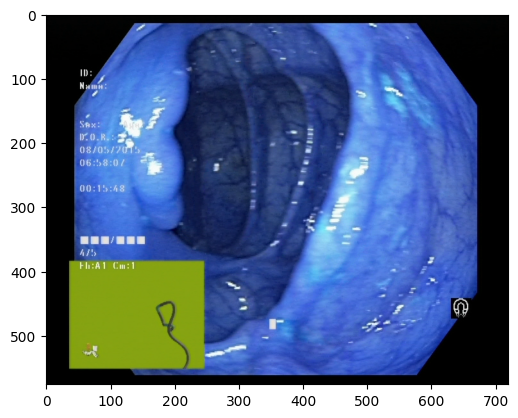

In [ ]:
#Reading an image (BGR is the default)
sample_image = cv2.imread(os.path.join(image_dir,image_files[0]))

#Displaying the sample
plt.imshow(sample_image)
plt.show()


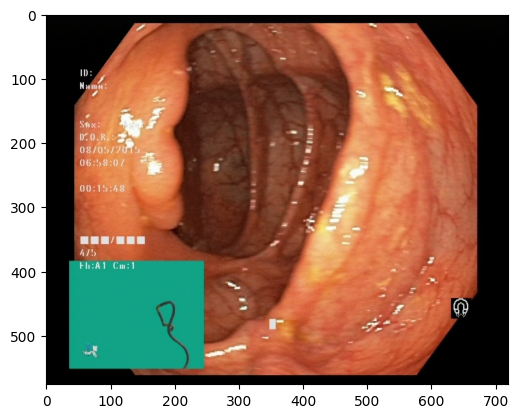

In [ ]:
#same sample in RGB
# Convert BGR to RGB
sample_image = cv2.imread(os.path.join(image_dir,image_files[0]))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

#Displaying the sample
plt.imshow(sample_image)
plt.show()

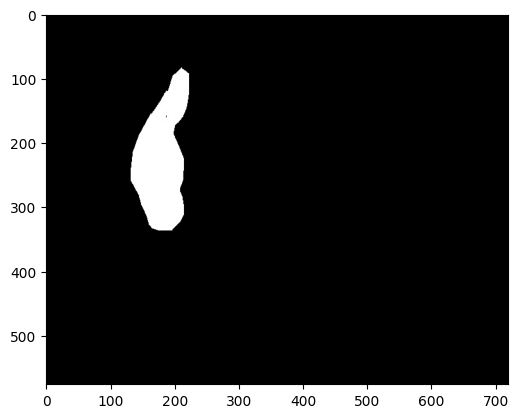

In [ ]:
#lets see 1st image mask
sample_mask_1 = cv2.imread(os.path.join(masks_dir,mask_files[0]))

#Display the mask
plt.imshow(sample_mask_1)
plt.show()

* Now we check shape of images and masks.


In [ ]:
print("Shape of image:", sample_image.shape)
print("Shape of mask", sample_mask_1.shape)

Shape of image: (576, 720, 3)
Shape of mask (576, 720, 3)


In traditional grayscale images, a single channel is typical. However, in our case, although the image appears grayscale, it actually consists of three channels (red, green, blue) with identical values in each channel for every pixel. This gives the visual impression of a grayscale image. To further understand the image's characteristics, we'll examine the minimum and maximum pixel values in both the RGB and mask images.

Next step is, checking maximum and minimum pixel values for both images and masks.

In [ ]:
#Min/Max pixel values

print("---RGB IMAGE---")
print("Max pixel value is:", sample_image.max())
print("Min pixel value is:", sample_image.min())

print("--------------------------")

print("---Segmented Image Mask---")
print("Max pixel value is:", sample_mask_1.max())
print("Min pixel value is:", sample_mask_1.min())


---RGB IMAGE---
Max pixel value is: 255
Min pixel value is: 0
--------------------------
---Segmented Image Mask---
Max pixel value is: 255
Min pixel value is: 0


In [ ]:
import cv2
import numpy as np
import os

# List all files in the directory
image_files = os.listdir(image_dir)

# Initialize an empty list to store the resized images
images = []

# Define the target dimensions for resizing
target_width = 256
target_height = 256

# Loop through each file in the directory
for file in image_files:
    # Read the image using OpenCV
    image_path = os.path.join(image_dir, file)
    img = cv2.imread(image_path)

    # Resize the image to the target dimensions
    resized_img = cv2.resize(img, (target_width, target_height))

    # Convert BGR to RGB format
    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

    # Convert the resized image to numpy array and append to the list
    images.append(rgb_img)

# Convert the list of images to a numpy array
images = np.array(images)


In [ ]:
images.shape

(1000, 256, 256, 3)

In [ ]:
import cv2
import numpy as np
import os

# List all files in the directory
mask_files = os.listdir(masks_dir)

# Initialize an empty list to store the resized and converted masks
masks = []

# Define the target dimensions for resizing
target_width = 256
target_height = 256

# Loop through each file in the directory
for file in mask_files:
    # Read the mask using OpenCV
    mask_path = os.path.join(masks_dir, file)
    mask = cv2.imread(mask_path)

    # Resize the mask to the target dimensions
    resized_mask = cv2.resize(mask, (target_width, target_height))

    # Convert the mask to grayscale
    gray_mask = cv2.cvtColor(resized_mask, cv2.COLOR_BGR2GRAY)

    # Convert the grayscale mask to numpy array and append to the list
    masks.append(gray_mask)

# Convert the list of masks to a numpy array
masks = np.array(masks)



In [ ]:
masks.shape


(1000, 256, 256)

In [ ]:
# Find the maximum and minimum pixel values in the masks array
max_pixel_value = np.amax(masks)
min_pixel_value = np.amin(masks)

print("Maximum pixel value for the masks:", max_pixel_value)
print("Minimum pixel value for the masks:", min_pixel_value)



Maximum pixel value for the masks: 255
Minimum pixel value for the masks: 0


In [ ]:

# Rescale the pixel values of masks to the range [0, 1]
masks = masks / max_pixel_value

# Find the maximum and minimum pixel values in the rescaled masks array
max_rescaled_value = np.amax(masks)
min_rescaled_value = np.amin(masks)

print("Maximum rescaled pixel value for the masks:", max_rescaled_value)
print("Minimum rescaled pixel value for the masks:", min_rescaled_value)

Maximum rescaled pixel value for the masks: 1.0
Minimum rescaled pixel value for the masks: 0.0


In [ ]:
# Find the maximum and minimum pixel values in each channel of the images array
max_pixel_values = np.amax(images, axis=(0, 1, 2))  # Max value for each channel
min_pixel_values = np.amin(images, axis=(0, 1, 2))  # Min value for each channel

print("Maximum pixel values (R, G, B):", max_pixel_values)
print("Minimum pixel values (R, G, B):", min_pixel_values)


Maximum pixel values (R, G, B): [255 255 255]
Minimum pixel values (R, G, B): [0 0 0]


In [ ]:
# Rescale the pixel values of images to the range [0, 1] for each channel
images = images / 255.0

# Find the maximum and minimum pixel values in each channel of the rescaled images array
max_rescaled_values = np.amax(images, axis=(0, 1, 2))  # Max value for each channel
min_rescaled_values = np.amin(images, axis=(0, 1, 2))  # Min value for each channel

print("Maximum rescaled pixel values (R, G, B):", max_rescaled_values)
print("Minimum rescaled pixel values (R, G, B):", min_rescaled_values)

Maximum rescaled pixel values (R, G, B): [1. 1. 1.]
Minimum rescaled pixel values (R, G, B): [0. 0. 0.]


In [ ]:

# Convert the data type to float32 for both images and masks
images = images.astype(np.float32)
masks = masks.astype(np.float32)

# Verify the data type conversion
print("After conversion to float32:")
print("Images dtype:", images.dtype)
print("Masks dtype:", masks.dtype)

After conversion to float32:
Images dtype: float32
Masks dtype: float32


* Both the RGB image and mask have the same minimum and maximum pixel values, minimum pixel value is 0 which represents black and max pixel values of 255 represents white.

*  Later in data preprocessing, data will be rescaled by dividing maximum pixel value of 255. Which ensures that data has consistent scale, in order to improve the performance.



In [ ]:
images.shape

(1000, 256, 256, 3)

In [ ]:
masks.shape

(1000, 256, 256)

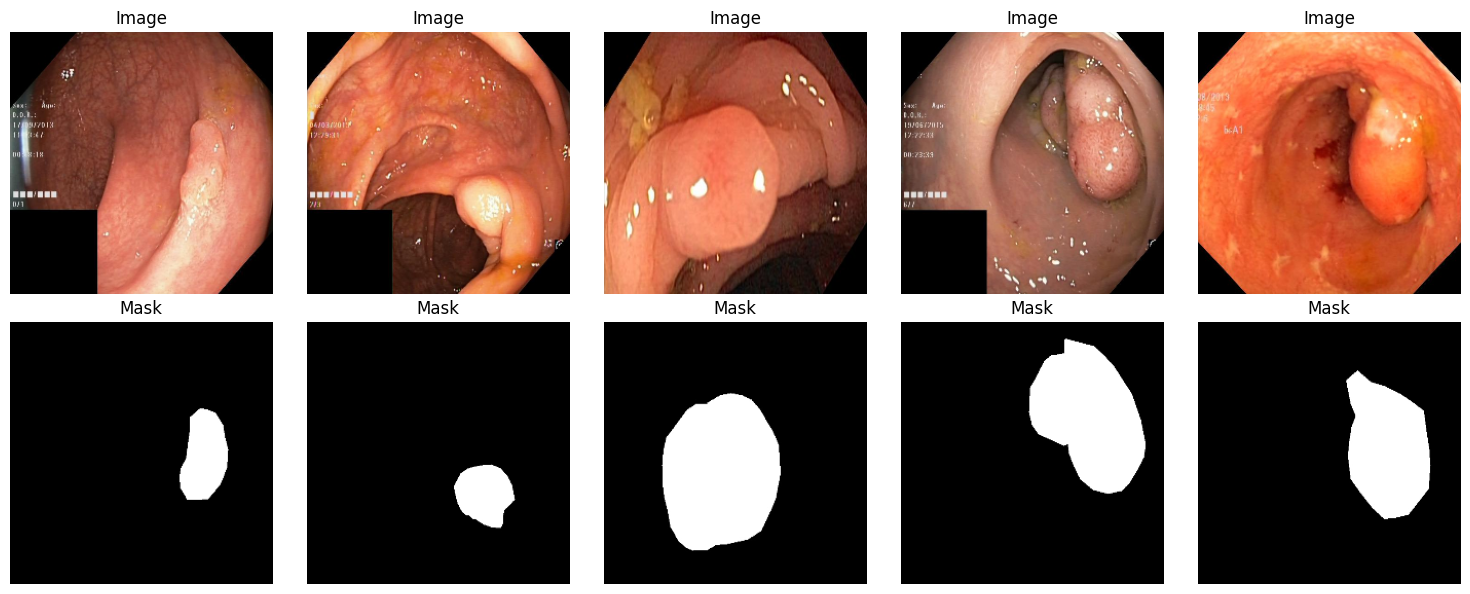

In [ ]:
import matplotlib.pyplot as plt
import random


# Set up the figure for plotting
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Randomly select 5 indices
random_indices = random.sample(range(len(images)), 5)

# Plot the images and masks
for i, idx in enumerate(random_indices):
    # Plot the image
    axes[0, i].imshow(images[idx])
    axes[0, i].set_title("Image")
    axes[0, i].axis("off")

    # Plot the mask
    axes[1, i].imshow(masks[idx], cmap='gray')
    axes[1, i].set_title("Mask")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
images.shape

(1000, 256, 256, 3)